In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import lightgbm as lgb
#import scipy
#from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestClassifier
plt.style.use('ggplot') 

In [ ]:
[f for f in os.listdir('.') if f[-3:] == "csv"]

In [3]:
train_trans = pd.read_csv("train_transaction.csv")
train_identity = pd.read_csv("train_identity.csv")

In [206]:
train_trans.head()

,Month,Week,Day,isNotFraud,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0,0,1,1,2987000,0,86400,68.5,W,13926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,1,2987001,0,86401,29.0,W,2755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,1,2987002,0,86469,59.0,W,4663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,1,1,2987003,0,86499,50.0,W,18132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,1,1,2987004,0,86506,50.0,H,4497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
isNotFraud = (~(train_trans["isFraud"] & True)).apply(int)
isNotFraud = isNotFraud.rename("isNotFraud")
train_trans = pd.concat([isNotFraud, train_trans], axis=1)

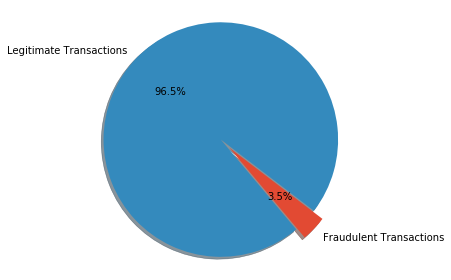

In [5]:
percent_fraud = train_trans["isFraud"].sum() / len(train_trans)
percent_not = 1 - percent_fraud
pie_slices = [percent_fraud, percent_not]
labels = ["Fraudulent Transactions", "Legitimate Transactions"]
fig1, ax1 = plt.subplots()
ax1.pie(pie_slices, explode=[0.1, 0], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=310)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [8]:
print(train_trans["isNotFraud"].sum())
print(train_trans["isFraud"].sum())

569877
20663


In [9]:
train_trans["isFraud"].sum() / train_trans["isNotFraud"].sum()

0.03625870143908247

In [12]:
missing_value_information = train_trans.isnull().sum() / len(train_trans)

In [30]:
0.25 * len(train_trans)

147635.0

In [42]:
(missing_value_information > 0.89).sum()

5

In [28]:
sum(missing_value_information[["V{}".format(i) for i in range(1, 340)]] > 0.76)

159

In [6]:
train_trans["card4"].unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

Text(0.5, 0, 'LogTransactionAmt')

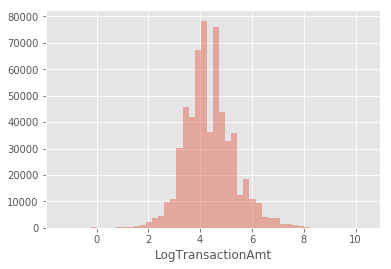

In [153]:
sns.distplot(train_trans["TransactionAmt"].apply(np.log), kde=False)
plt.xlabel("LogTransactionAmt")

In [8]:
train_trans["ProductCD"].unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

Text(0.5, 0, 'LogTransactionAmt')

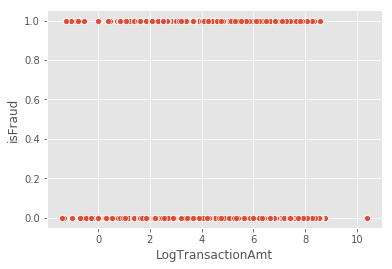

In [9]:
sns.scatterplot(x=train_trans["TransactionAmt"].apply(np.log), y=train_trans["isFraud"])
plt.xlabel("LogTransactionAmt")

In [177]:
log_sincere_amounts = train_trans[train_trans["isNotFraud"] & True]["TransactionAmt"].apply(np.log)

(2, 7)

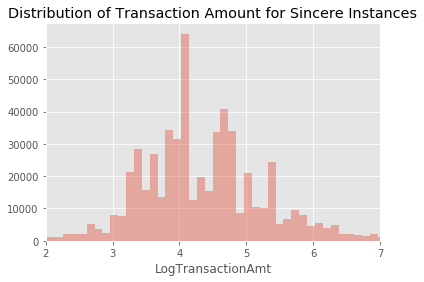

In [178]:
sns.distplot(log_sincere_amounts, kde=False, bins=100)
plt.xlabel("LogTransactionAmt")
plt.title("Distribution of Transaction Amount for Sincere Instances")
plt.xlim([2, 7])

In [179]:
log_fraud_amounts = train_trans[train_trans["isFraud"] & True]["TransactionAmt"].apply(np.log)

(1, 7)

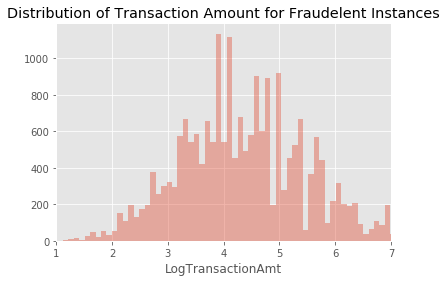

In [180]:
sns.distplot(log_fraud_amounts, kde=False, bins=100)
plt.xlabel("LogTransactionAmt")
plt.title("Distribution of Transaction Amount for Fraudelent Instances")
plt.xlim([1, 7])

In [184]:
sample_size = len(log_fraud_amounts)

In [186]:
mean_divergence = 0
for i in range(10):
    kl_divergence = scipy.stats.entropy(log_fraud_amounts, log_sincere_amounts.sample(sample_size))
    print(kl_divergence)
    mean_divergence += kl_divergence

mean_divergence /= i
print(mean_divergence)

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


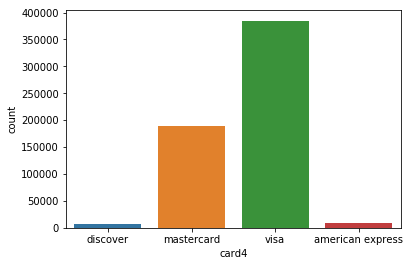

In [9]:
sns.countplot(train_trans["card4"])

In [10]:
not_fraud_grouped_by_card = train_trans.groupby("card4")["isNotFraud"].sum()

In [11]:
fraud_grouped_by_card = train_trans[["isFraud", "card4"]].groupby("card4")["isFraud"].sum()

In [12]:
fraud_grouped_by_card / (fraud_grouped_by_card + not_fraud_grouped_by_card)

card4
american express    0.028698
discover            0.077282
mastercard          0.034331
visa                0.034756
dtype: float64

Text(0.5, 15.0, 'Fraud as ratio of type of card used')

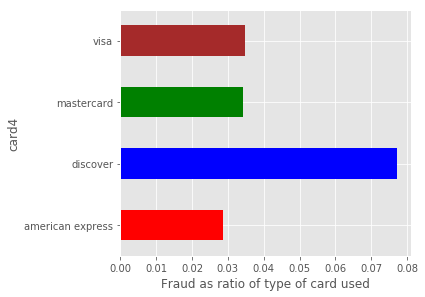

In [13]:
(fraud_grouped_by_card / (fraud_grouped_by_card + not_fraud_grouped_by_card)).plot.barh(color=["red", "blue", "green", "brown"])
plt.tight_layout()
plt.xlabel("Fraud as ratio of type of card used")

In [14]:
not_fraud_grouped_by_cd = train_trans.groupby("ProductCD")["isNotFraud"].sum()
fraud_grouped_by_cd = train_trans[["isFraud", "ProductCD"]].groupby("ProductCD")["isFraud"].sum()

Text(0.5, 0, 'Fraud as ratio of product code')

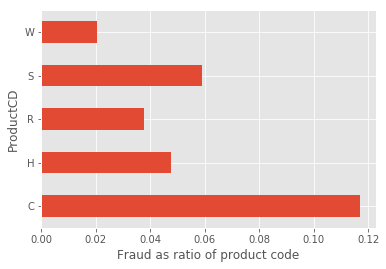

In [15]:
(fraud_grouped_by_cd / (fraud_grouped_by_cd + not_fraud_grouped_by_cd)).plot.barh()
plt.xlabel("Fraud as ratio of product code")

In [237]:
train_trans.query("card4 == 'discover'")["ProductCD"].unique()  # Completely independent from product code 'C'

array(['W', 'S', 'H', 'R'], dtype=object)

In [141]:
train_trans["TransactionDT"].iloc[-1]

15811131

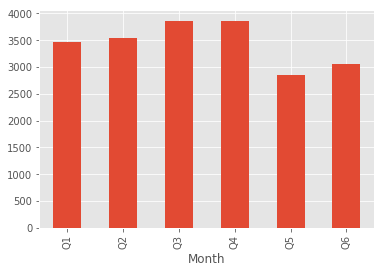

In [27]:
diff = (train_trans["TransactionDT"].iloc[-1] - train_trans["TransactionDT"].iloc[0]) / 6
bins = [train_trans["TransactionDT"].iloc[0] - 1 + i*diff for i in range(7)]
bins[-1] += 1
months = pd.cut(train_trans["TransactionDT"],
           bins=bins, 
           labels=["Q1", "Q2", "Q3", "Q4", "Q5", "Q6"])
months = months.rename("Month")
pd.concat([months, train_trans], axis=1).groupby("Month")["isFraud"].sum().plot.bar() # Number of fraud per month

In [269]:
email_fraud = train_trans.groupby("P_emaildomain")["isFraud"].sum()
not_email_fraud = train_trans.groupby("P_emaildomain")["isNotFraud"].sum()
sorted_email_fraud_counts = (email_fraud).sort_values()

In [135]:
def correlated_feature_deletion(corr, prefix, thres):
    columns_left = [idx for idx in range(1, len(corr.columns) + 1)]
    deleted_columns = []
    while True:
        done = True
        for col_id in range(len(columns_left) - 1):
            for col2_id in range(col_id + 1, len(columns_left)):
                if corr["{}{}".format(prefix, columns_left[col_id])]["{}{}".format(prefix, 
                                                                                   columns_left[col2_id])] > thres:
                    corr = corr.drop(["{}{}".format(prefix, columns_left[col2_id])], axis=1)
                    corr = corr.drop(["{}{}".format(prefix, columns_left[col2_id])], axis=0)
                    done = False
                    break
            if not done:
                deleted_columns.append(columns_left[col2_id])
                del columns_left[col2_id]
                break
        if done:
            break
    return corr, deleted_columns

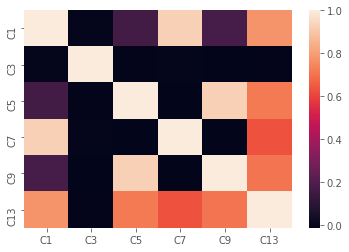

In [136]:
corr = train_trans[["C{}".format(i) for i in range(1, 15)]].corr()
corr, deleted_columns = correlated_feature_deletion(corr, 'C', 0.95)

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

train_trans = train_trans.drop(["C{}".format(del_id) for del_id in deleted_columns], axis=1)

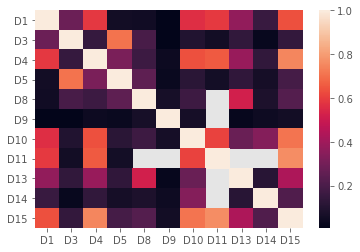

In [137]:
corr = train_trans[["D{}".format(d_id) for d_id in range(1, 16)]].corr()
corr, deleted_columns = correlated_feature_deletion(corr, 'D', 0.95)

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

train_trans = train_trans.drop(["D{}".format(del_id) for del_id in deleted_columns], axis=1)

In [99]:
# corr = train_trans[[i for i in train_trans.columns if i[0] == 'D']].corr()

train_trans[["D11", "D6"]].isnull().sum()

D11    279287
D6     517353
dtype: int64

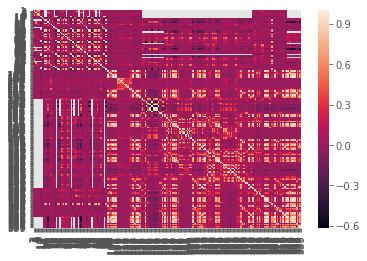

In [368]:
corr = train_trans[[i for i in train_trans.columns if i[0] == 'V']].corr()
sns.heatmap(corr, 
        xticklabels=[i for i in range(1, len(corr.columns) + 1)],
        yticklabels=[i for i in range(1, len(corr.columns) + 1)])

In [55]:
[i for i in train_trans.columns if i[0] == 'M']

['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [69]:
day = train_trans["TransactionDT"].apply(lambda td: int(td / 86400))
day = day.rename("Day")
train_trans = pd.concat([day, train_trans], axis=1)

In [70]:
fraud_by_day = train_trans.groupby("Day")["isFraud"].sum()

Text(0.5, 1.0, 'Fraud Aggregated by Day')

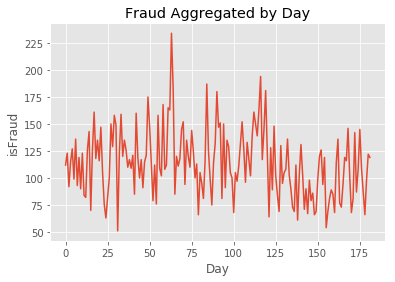

In [73]:
sns.lineplot(x=range(len(fraud_by_day)), y=fraud_by_day)
plt.xlabel("Day")
plt.title("Fraud Aggregated by Day")

In [84]:
adfuller(fraud_by_day)

(-9.76161740314601,
 7.536728221076229e-17,
 0,
 181,
 {'1%': -3.467004502498507,
  '5%': -2.8776444997243558,
  '10%': -2.575355189707274},
 1614.4799275614712)

In [74]:
week = train_trans["TransactionDT"].apply(lambda td: int(td / (7*86400)))
week = week.rename("Week")
train_trans = pd.concat([week, train_trans], axis=1)

In [80]:
fraud_by_week = train_trans.groupby("Week")["isFraud"].sum()
fraud_by_week = fraud_by_week[:26]

In [86]:
adfuller(fraud_by_week)

(-0.471766070576307,
 0.8974093964168033,
 7,
 18,
 {'1%': -3.859073285322359,
  '5%': -3.0420456927297668,
  '10%': -2.6609064197530863},
 195.4847499213571)

Text(0.5, 1.0, 'Fraud Aggregated by Week')

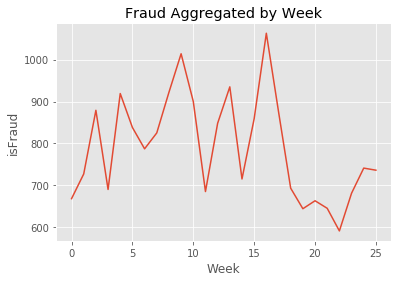

In [81]:
sns.lineplot(x=range(len(fraud_by_week)), y=fraud_by_week)
plt.xlabel("Week")
plt.title("Fraud Aggregated by Week")

In [87]:
month = train_trans["TransactionDT"].apply(lambda td: int(td / (30*86400)))
month = month.rename("Month")
train_trans = pd.concat([month, train_trans], axis=1)

In [89]:
fraud_by_month = train_trans.groupby("Month")["isFraud"].sum()
fraud_by_month = fraud_by_month[:6]

In [91]:
fraud_by_month

Month
0    3243
1    3627
2    3700
3    3849
4    2962
5    2943
Name: isFraud, dtype: int64

In [256]:
hour_of_day = (((train_trans["TransactionDT"] - 86400) / 3600) % 24).apply(lambda x: int(x))
hour_of_day = hour_of_day.rename("HourOfDay")
train_trans = pd.concat([hour_of_day, train_trans], axis=1)

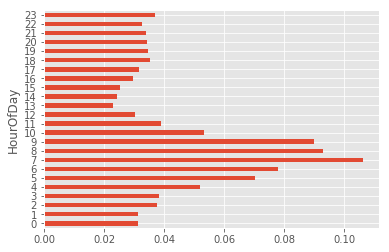

In [281]:
fraud_grouped_by_hour = train_trans.groupby("HourOfDay")["isFraud"].sum()
not_fraud_grouped_by_hour = train_trans.groupby("HourOfDay")["isNotFraud"].sum()

(fraud_grouped_by_hour / (fraud_grouped_by_hour + not_fraud_grouped_by_hour)).plot.barh()

In [116]:
def replace_with_one_hot(df, col):
    prefix = col
    col = df[col]
    dummies = pd.get_dummies(col, prefix=prefix)
    df = df.drop(prefix, axis=1)
    df = pd.concat([dummies, df], axis=1)
    return df

In [227]:
for i in train_trans.columns:
        train_trans[i] = train_trans[i].fillna(train_trans[i].mode()[0])

In [229]:
train_trans = replace_with_one_hot(train_trans, "ProductCD")

In [235]:
for col in train_trans.columns:
    if isinstance(train_trans.iloc[0][col], str):
        train_trans = replace_with_one_hot(train_trans, col)

In [240]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
sampled_df = train_trans.sample(20000)
sampled_df = sampled_df.drop("isNotFraud", axis=1)
rf.fit(sampled_df.drop("isFraud", axis=1), sampled_df["isFraud"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [241]:
sorted(list(zip(sampled_df.drop("isFraud", axis=1).columns, rf.feature_importances_)), key=lambda tup: tup[1])

[('M1_F', 0.0),
 ('M1_T', 0.0),
 ('R_emaildomain_embarqmail.com', 0.0),
 ('R_emaildomain_frontiernet.net', 0.0),
 ('R_emaildomain_hotmail.de', 0.0),
 ('R_emaildomain_netzero.net', 0.0),
 ('R_emaildomain_ptd.net', 0.0),
 ('R_emaildomain_q.com', 0.0),
 ('R_emaildomain_rocketmail.com', 0.0),
 ('R_emaildomain_sc.rr.com', 0.0),
 ('R_emaildomain_scranton.edu', 0.0),
 ('R_emaildomain_suddenlink.net', 0.0),
 ('R_emaildomain_twc.com', 0.0),
 ('R_emaildomain_windstream.net', 0.0),
 ('R_emaildomain_yahoo.co.jp', 0.0),
 ('R_emaildomain_yahoo.co.uk', 0.0),
 ('R_emaildomain_yahoo.es', 0.0),
 ('P_emaildomain_hotmail.de', 0.0),
 ('P_emaildomain_yahoo.co.jp', 0.0),
 ('P_emaildomain_yahoo.co.uk', 0.0),
 ('P_emaildomain_yahoo.de', 0.0),
 ('card6_charge card', 0.0),
 ('card6_debit or credit', 0.0),
 ('V107', 0.0),
 ('V241', 0.0),
 ('V305', 0.0),
 ('R_emaildomain_frontier.com', 3.1806003101027804e-10),
 ('R_emaildomain_netzero.com', 2.6998264431290618e-09),
 ('V1', 1.2890703736844915e-08),
 ('P_emaildomain